In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

import gc
import pickle as pickle

from sklearn.model_selection import KFold
from itertools import product
import tensorflow as tf
from sklearn.preprocessing import StandardScaler,MinMaxScaler 
import multiprocessing as mp
import importlib
from sklearn.model_selection import train_test_split

In [3]:
#tail -n +2 train.csv | split -l 150000


In [4]:
from os import listdir
from os.path import isfile, join

TRAIN_SPLITS='train'
splits = [f for f in listdir(TRAIN_SPLITS) if isfile(join(TRAIN_SPLITS, f))]

In [ ]:
path = 'train/%s' % (np.random.choice(splits))
#
columns = ['acoustic_data','time_to_failure']
df = pd.read_csv(path, float_precision='round_trip', header=None)
df.columns = columns

df.describe()

In [ ]:
path1 = 'train/%s' % (np.random.choice(splits))
#
columns = ['acoustic_data','time_to_failure']
df1 = pd.read_csv(path1, float_precision='round_trip', header=None)
df1.columns = columns

path2 = 'train/%s' % (np.random.choice(splits))
#
columns = ['acoustic_data','time_to_failure']
df2 = pd.read_csv(path2, float_precision='round_trip', header=None)
df2.columns = columns

In [ ]:
np.random.choice(np.array([1,2,3,4]))
for i in range(0,20):
    print(i)

In [ ]:
acoustic_data = np.array_split(df['acoustic_data'].values, 300)

np.random.choice(acoustic_data[0])

In [ ]:

#last_n=int(SEGMENT_LENGTH/timesteps/4)
acoustic_data = np.array_split(df['acoustic_data'].values, 500)
#means = np.array([np.mean(sub[-last_n:], dtype=np.float64) for sub in acoustic_data])
data = np.array([(np.mean(sub),np.max(sub),np.min(sub)) for sub in acoustic_data])
target = df['time_to_failure'].values[-1]
#
df2 = pd.DataFrame(data)
df2.columns = ["mean", "max", "min"]

In [ ]:
df2

In [ ]:
a = np.array([1,2,-3,4,50,-1,2,3])
a[a > 3]

In [9]:
TIMESTEPS=150

import build_segment
importlib.reload(build_segment)

from build_segment import build_segment_f

split_chunks = np.array_split(splits,mp.cpu_count())

if __name__ ==  '__main__':
    pool = mp.Pool(mp.cpu_count())
    res = [pool.apply_async(build_segment_f,args=[chunk,TIMESTEPS]) for chunk in split_chunks]
    pool.close()
    pool.join()

0
0
0
0
0
0
0
0
100
100
100
100
100
100
100
100
200
200
200
200
200
200
200
200
300
300
300
300
300
300
300
300
400
400
400
400
400
400
400
400
500
500
500
500
500
500
500
500


In [ ]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

res[0].get()[100]

In [10]:
NUMBER_OF_FEATURES=len(res[0].get()[0].drop('time_to_failure', axis=1).columns)

training = np.empty((len(splits),TIMESTEPS,NUMBER_OF_FEATURES),dtype=float)
targets = np.empty((len(splits),1),dtype=float)
i=0
for r in res:
    for df in r.get():
        training[i] = df.drop('time_to_failure', axis=1)
        targets[i] = np.array([df['time_to_failure'].unique()])
        i+=1

In [ ]:
res[0].get()[0]

In [ ]:
res[0].get()[0][['acoustic_data', 'rolling_10', 'rolling_50', 'rolling_100', 'min_50',
       'max_50', 'std_50']].shape

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16)                2176      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 2,193
Trainable params: 2,193
Non-trainable params: 0
_________________________________________________________________
Train on 3775 samples, validate on 420 samples
Epoch 1/100
3775/3775 [==============================] - 8s 2ms/step - loss: 4.1846 - mean_absolute_error: 4.1846 - val_loss: 3.0721 - val_mean_absolute_error: 3.0721
Epoch 2/100
3775/3775 [==============================] - 7s 2ms/step - loss: 3.0351 - mean_absolute_error: 3.0351 - val_loss: 3.0361 - val_mean_absolute_error: 3.0361
Epoch 3/100
3775/3775 [==============================] - 7s 2ms/step - loss: 3.0069 - mean_absolute_error: 3.0069 - val_loss: 3.0124 - val_mean_absolute_er

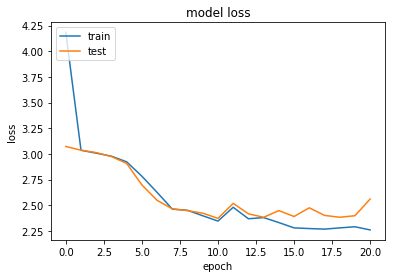

In [11]:
train_data, val_data, y_train, y_val = train_test_split(training, targets, test_size=0.1, random_state=42)

from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Flatten,GRU#,CuDNNGRU,CuDNNLSTM
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers import Bidirectional



dropout=0.2
BATCH_SIZE=32


my_model = Sequential()


my_model.add(LSTM(use_bias = True,unit_forget_bias=True,\
                  units = 16,\
                  input_shape=(TIMESTEPS, NUMBER_OF_FEATURES),
                  #dropout=dropout,recurrent_dropout=dropout,
                  #return_sequences=True
                  ))

#my_model.add(BatchNormalization())


                 
                    
#my_model.add(Dense(8))
#my_model.add(BatchNormalization())
my_model.add(Dense(1))

my_model.compile(loss = 'mae',optimizer = 'adam', metrics = ['mean_absolute_error'])
my_model.summary()

from keras.callbacks import Callback

class Reseter(Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.reset_states()


callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=0),
    #Reseter()
]

history = my_model.fit(train_data, y_train, batch_size=BATCH_SIZE, epochs=100, shuffle=True,
                      validation_data=(val_data,y_val), callbacks=callbacks
                    )


import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#import math
#print("best rmse val:", math.sqrt(my_model.history.history['val_mean_squared_error'][-1]))

In [ ]:
TEST_SPLITS='test'
test_splits = [f for f in listdir(TEST_SPLITS) if isfile(join(TEST_SPLITS, f))]

In [ ]:
test_splits

In [ ]:
test_split_chunks = np.array_split(test_splits,mp.cpu_count())

import build_segment
importlib.reload(build_segment)

from build_segment import build_segment_f

if __name__ ==  '__main__':
    pool = mp.Pool(mp.cpu_count())
    res = [pool.apply_async(build_segment_f,args=[chunk,TIMESTEPS, True]) \
           for chunk in test_split_chunks]
    pool.close()
    pool.join()

In [ ]:
ids = []
preds = []
i=0
for r in res:
    for df in r.get():
        if i % 100 == 0:
            print(i)
        #training[i] = df.loc[:,df.columns != 'time_to_failure']
        ids.append(df['seg_id'].unique()[0].split(".")[0])
        test_df = df.drop('seg_id', axis=1)
        preds.append(my_model.predict(test_df.values.reshape(1,-1,NUMBER_OF_FEATURES))[0][0])
        i+=1

In [ ]:
submission = pd.DataFrame(ids)
submission.columns = ['seg_id']
submission['time_to_failure'] = preds

submission.to_csv('submission.csv', index=False)

In [ ]:
submission["time_to_failure"].describe()

In [ ]:
submission["time_to_failure"].describe()

In [ ]:
submission.head()

In [ ]:
preds

In [ ]:
res[0].get()[0]

In [ ]:
path = 'test/%s' % (np.random.choice(test_splits))
#

df = pd.read_csv(path, float_precision='round_trip', header=[0])


df.describe()